# Modificaciones : sin Taylor1, con Inverse Power 


Antes de seguir probando la automarización que hemos logrado debemos hacer algunas mejoras. Para ellos revisaremos cada función y de ser posible haremos más simples algunas cosas y omitiremos aquellas que sean redundantes. Es punto de esto es hacer un prógrama mejor automatizado y más simple.

In [2]:
using TaylorSeries
using PyPlot
using LinearAlgebra
#using GenericSVD

La idea es quitar la necesidad de tener que usar Taylor1, ya que en las funciones de jacobian no se tiene definidas alginas cosas para Taylor1.TaylorN mientras que sí fúnciona para Taylor N. Recordemos que hay que revisar la estabilidad de las respuestas en cada paso. 
La diferencia entre el notebook anterior y este es que aislaremos la parte de g=1 del método.

In [3]:
"""

PolinomioTaylor(Cθ,CP, TipoVariable)
   
   Es una función cuyo objetivo es recibir dos listas con valores iniciales y crear dos polinomios de grado 1.




Argumentos:


   - Cθ,CP  :  Arreglo que contiene los coeficientes iniciales, es del tipo Array{TaylorSeries.TaylorN{Float64}}
   - TipoVariable :  es el tipo de número que queremos uasr: Real, Float64, BigFloat, etc.
   

    Esta función regresa dos arreglos que contienen elementos del tipo Taylor1.TaylorN, creados con los valores propios del sistema.


"""
function PolinomioTaylor(Cθ,CP,TipoVariable)
    #=  
    Separamos el primer orden puesto que es diferente de los otros.
    Creamos θ,p como variables tipo TaylorN de orden 2, recordemos que aquí es importante el orden puesto que si se usan
    más adelante para otras operaciones el polinomio se puede cortar si no se define adecuadamente
    =#
    
    
    
    θ,p = set_variables(TipoVariable, "θ p", order=2)
    
    #especificamos que Lθ,LP son de arreglos que guardarán coeficientes del polinomio, sólo son auxiliares en esta función
    
   
   # Lθ = Array{TaylorSeries.TaylorN{TipoVariable}}(1)
   # LP = Array{TaylorSeries.TaylorN{TipoVariable}}(1)
        
    T = [Taylor1([θ], 1),Taylor1([p], 1)]
    return T
end
    



PolinomioTaylor

In [4]:
"""

PolinomioTaylor1(g,Cθ,CP, TipoVariable)
   
   Es una función cuyo objetivo es recibir dos listas con valores iniciales y crear dos polinomios de grado g.




Argumentos:





   - g       : grado del polinomio
   - Cθ,CP  :  Arreglo que contiene los coeficientes iniciales, es del tipo Array{TaylorSeries.TaylorN{Float64}}
   - TipoVariable :  es el tipo de número que queremos uasr: Real, Float64, BigFloat, etc.
   

    Esta función regresa dos arreglos que contienen elementos del tipo Taylor1.TaylorN, creados con las listas iniciales. 
    Funciona específicamente para orden g>1.


"""
function PolinomioTaylor1(g::Real,Cθ,CP,TipoVariable)
    #=
    g es el grado del polinomio, CX y CP son
    arreglos que contienen los coeficientes que forman la variedad.
    
    
    Creamos x,p como variables tipo TaylorN de orden 2
    =#
    
    
    
    θ,p = set_variables(TipoVariable, "θ p", order=2)
    
    #especificamos que LX,LP son de arreglos que guardarán coeficientes del polinomio, sólo son auxiliares en esta función
    
   
    Lθ = Array{TaylorSeries.TaylorN{TipoVariable}}(1)
    LP = Array{TaylorSeries.TaylorN{TipoVariable}}(1)
    
    
    
    
        #como CX,CP están guardando los coeficientes pero necesitamos agregar el último término que será una variable 
        
    Lθ = push!(Cθ, θ) 
    LP = push!(CP, p)

    T=[Taylor1(Lθ, g),Taylor1(LP, g)]
        
    
    return T
end
#Esta función regresa tθ,tp que son Taylor1.TaylorN

PolinomioTaylor1

In [5]:
#=Esta función toma el arreglo que contiene las lambdas que se van calculando, los coeficientes de los polinomios
y el orden de los mismos, lo que hace es generar el lado derecho de la ecuación cohomológica, multiplicando a_n*λ^n
y generando un polinomio de gradno g con estos coeficientes
=#
"""
Vecλ(λ_v,g,Cθ,CP)
Es una función que calcula la parte derecha de la ecuación comohológica, es decir la parte que involucra el valor propio.
Regresa un arreglo de tipo TaylorSeries.TaylorN{Float64}


Sus argumentos son:
-g      :  grado del polinomio.
-λ_v    :  Arreglo de dos dimensiones que contiene el valor propio y sus potencias. 
-Cθ,CP  :  Los arreglos con los polinomios que se calculan en PolinomioTaylor1.

"""
function Vecλ(λ_v,g,Cθ,CP)
   # el arreglo de λ_v contiene los arreglos que corresponden a la parte derecha de la ecuación cohomológica
    # en θ,p. Es importante hacer la distinción puesto que dependiendo del punto fijo donde se esté calculando
    # el primer valor de λ en θ serpa diferente del primer valor de λ en P
    θλt=Taylor1(λ_v[1].*Cθ,g)
    pλt=Taylor1(λ_v[2].*CP,g)
    
    λvec=[θλt,pλt]
    
    return λvec
end

Vecλ

In [6]:
"""
EigenValores(M)


Función que calcula los valores y vectores propios para una matriz de elementos de tipo BogFloat.
El método usado es el de Inverse Power Method 




Argumentos:
-M: Matriz tipo BigFloat (2-element Array{BigFloat,1})
"""
function EigenValores(M)
    # MM sirve como matriz auxiliar para el cálculo de eigenvalores con la función eig()
    
    MM = [Float64(M[1]) Float64(M[3]); Float64(M[2]) Float64(M[4])]
    λfloat,vfloat = eig(MM)
    #Por otra parte calculamos los valores propios de M usando :
    Vals = real(LinearAlgebra.EigenGeneral.eigvals!(M))
    #Creamos matrices que nos ayudarán en el método
    Id = [big(1.) big(0.); big(0.) big(1.)] #matriz identidad
    EigVec=[big(0.) big(0.);big(0.) big(0.)] #MAtriz que guardará los vectores propios
    ValsOrden=[big(0.0),big(0.)] #guardará los valores propios ordenados 
    
    #vec_i =([0.6,0.3],[1.,0.]) #debemos dar un vector inicial para el cálculo
    
    #k recorre los dos valores propios
    for k in [1,2]
        #la tolerancia sirve para saber cuando paramos el método
        tol = 0.0
        
        vec_i = big(rand(2,1)) # el vector inicial será un vector random
        # comienza el método
        #for i in[1:10]
            
        while abs(tol)<1e-180
            
            H = inv(M-Vals[k]*Id)*vec_i #calculamos H
            
            vec_n = H/norm(H) #normalizamos
            vec_i =vec_n #actualizamos
            #vec_i[k][1] = vec_n[1]
            #vec_i[k][2] = vec_n[2]
            tol = norm(MM*vec_i-Vals[k]*vec_i,Inf)  #calculamos el error o discrepancia
        end
        
    
        if abs(λfloat[1]-Vals[k])<1e-10

            ValsOrden[1]=sign(λfloat[1])*abs(Vals[k])
            EigVec[1]=sign(vfloat[1])*abs(vec_i[1])
            EigVec[2]=sign(vfloat[2])*abs(vec_i[2])
            
        else
            
            ValsOrden[2]=sign(λfloat[2])*abs(Vals[k])
            EigVec[3]=sign(vfloat[3])*abs(vec_i[1])
            EigVec[4]=sign(vfloat[4])*abs(vec_i[2])
    
        end
            
        
    end
    
    #V=(ValsOrden,EigVec)
    
    return ValsOrden,EigVec
        
        
        
    
end     

EigenValores

In [7]:
function Orden1(Cθ,CP,TipoVariable,Mapeo,k,l,PuntoFijo,tipo_v,λarrayθ,λarrayP)
            #usamos la función PolinomioTaylor para crear el polinomio tipo Taylor1.TaylorN{T}
            eigval=TipoVariable[0.,0.]
            eigvec=TipoVariable[0. 0.; 0. 0.]
            t = PolinomioTaylor(Cθ,CP,TipoVariable)
            @show(typeof(t))
            #Aplicamos el mapeo a los polinomios que resultan de la función anterior.
            Or1 = Mapeo(t[1],t[2],k,l)
            @show(typeof(Or1))
            AuxOr1=[Or1[1][1],Or1[2][1]]
            @show(typeof(AuxOr1))
            #Calculamos el jacobiano del Orden 1 para obtener sus valores y vectores propios.
            JPO = jacobian(AuxOr1,[PuntoFijo[1],PuntoFijo[2]])
            @show(typeof(JPO))
            
            
            #Calculamos los valores y vectores propios
            if TipoVariable == BigFloat
                eigval,eigvec = EigenValores(JPO)
            else
                eigval,eigvec = eig(JPO)
            end
            #escogemos el tipo de variedad que queremos calcular. Como se ordenan de menor a mayor la inestable es la segunda
            λ = eigval[tipo_v]
            
            #Ponemos los coeficientes en una variable nueva cada uno y los agregamos a las listas CX,CP,λ
            Coefθ,CoefP = eigvec[:,tipo_v]
            @show(typeof(Coefθ))
            #@show(Coefθ,CoefP)
            push!(Cθ, Coefθ)
            push!(CP, CoefP)
            push!(λarrayθ, λ)
            push!(λarrayP, λ)
            λ_v=[λarrayθ,λarrayP]
            
            #@show(λarray)  
            @show(typeof(Cθ))
            @show(typeof(λarrayθ))
    return Cθ, CP,λarrayθ,λarrayP, λ_v
end
            
    

Orden1 (generic function with 1 method)

In [8]:
#Creamos una función que reciba el orden del polinomio , el punto fijo, el parámetro k y 
#el tipo de varidad que queremos(estable=1, inestable=2)
"""
Variedades(Mapeo,orden, PuntoFijo,k,tipo_v,TipoVariable)
Es una función que calcula las variedades de cierto mapeo. Usa las funciones de PolinomioTaylor1 y Vecλ para calcular los
polinomios de cada lado de la ecuación cohomológica y les aplica el mapeo dado. 



Argumentos:


- Mapeo : Mapeo de dos dimensiones, debe recibir al menos dos parámetros que son los polinomios antes calculados.
- orden : se trata del orden del polinomio.
- PuntoFijo : ES el punto fijo donde queremos calcular la variedad.
- k     : Es la constante del mapeo.
- tipo_v : 1 si la variedad es estable, 2 si es inestable.
- TipoVariable :  Float64,BigFloat, Integer,etc.


"""
function Variedades(Mapeo,orden, PuntoFijo,k,l,tipo_v, TipoVariable)
   
    #definimos unas listas donde se guardarán los coeficientes  de todo el polinomio, tales deben ser
    # de tipo "Array{TaylorSeries.TaylorN{Int64},1}" dado que los términos que se van agregando 
    # en cada orden son de tipo TaylorN.
    
    a=TipoVariable(PuntoFijo[1])
    b=TipoVariable(PuntoFijo[2])
    Cθ = [a+TaylorN(0.)]
    CP = [b+TaylorN(0.)]
    
    
    #λarray es la lista que contiene a los coeficientes del polinomio de λ
    λarrayθ = [a^0]
    λarrayP = [b^0]
    
    #definimos un vector que contiene el punto en el que se evalúa el jacobiano que se calcula después
    #dado que sólo lo usamos para obtener los valores que resultaron en el mapeo evaluamos siempre en [1.,1.]
    
    
    
    
    Cθ,CP,λarayθ, λarrayP,λ_v = Orden1(Cθ,CP,TipoVariable,Mapeo,k,l,PuntoFijo,tipo_v,λarrayθ,λarrayP)
    


    for g in 2:orden
        
            #Creamos los polinomios con las listas correspondientes 
            t = PolinomioTaylor1(g,Cθ,CP,TipoVariable)
            
            # aplicamos el mapeo estándar y al resultado le llamamos OrG por Orden g.
            OrG = Mapeo(t[1],t[2],k,l)
            
            push!(λarrayθ,λarrayθ[2]^g)
            push!(λarrayP,λarrayP[2]^g)
            λ_v=[λarrayθ,λarrayP]
            
            #agregamos el término correspondiente a λ 
            λ_vec=Vecλ(λ_v,g,Cθ,CP)
            
            
            #@show(λvec)
            
            # ahora ya tengo las dos partes de la ecuación y debo igualarlas para resolver.
            EcuaCohomo=OrG-λ_vec
            
            
            # de esta ecuación necesitamos solo los de orden g, así que los extraemos manualmente 
            θ_g=EcuaCohomo[1].coeffs[g+1]
            p_g=EcuaCohomo[2].coeffs[g+1]
            vec_orden_g=[θ_g,p_g]
            
            
            #calculamos el término independiene en la ecuación
            θ_ind=EcuaCohomo[1].coeffs[g+1].coeffs[1].coeffs[1]
            p_ind=EcuaCohomo[2].coeffs[g+1].coeffs[1].coeffs[1]
            vec_ind=[-θ_ind,-p_ind]
            
            #calculamos el jacobiano
            JacOrdenG = jacobian(vec_orden_g)
            
            
            
            
            #Con esta información podemos evaluar lo siguiente:
            # Si el vector de términos independientes es cero y el determinante del jacobiano es distinto de cero
            # entonces la solución a la ecuación cohomológica es la trivial
            if norm(vec_ind)==0.
                if det(JacOrdenG)!=0.
                    
                    Cθ[g+1]=0.
                    CP[g+1]=0.
                end
            else
                # Si el vector de términos independientes es distinto de ceroentonces necesitamos 
                #resolver la ecuación JacOrdenG[x_g,p_g]*[x,p]**=vec_ind[x_g,p_g]
                # entonces solo se trata de invertir el jacobiano y multiplicar con el vector del lado izquierdo
                TermG=JacOrdenG \ vec_ind
                
                Cθ[g+1]=TermG[1]
                CP[g+1]=TermG[2]
            
            end
            

    end
    return Cθ,CP,λarrayθ, λarrayP
end

Variedades

In [9]:
"""
PolinomioCohomo(Mapeo,Pol_vec,λvec, k)
Esta función calcula la ecuación cohomológica con los polinomios que ya se calcularon. Regresa un arreglo de dos 
elementos que son los valores de x,θ del mapeo.


Argumentos:
-Mapeo : función o mapeo del cual calculamos las variedades.Debe ser una función que reciba tres parámetros
 que son dos de sus variables y la constante del mapeo. Como salida debe tener un arreglo de dos elementos. 
-Pol_vec : Es un arreglo de dos elementos que son los polinomios calculados con anterioridad. 
-k     : es el valor de la constante del mapeo 
-λvec : 

"""
function PolinomioCohomo(Mapeo,Pol_vec,λvec, k,l ,PuntoFijo,modulo)
    Map_vec=Mapeo(Pol_vec[1],Pol_vec[2],k,l)
    if modulo==2*pi
        Ec_Cohomo = mod(Map_vec-λvec,modulo)
    else
    Ec_Cohomo = Map_vec-λvec
    end
    return Ec_Cohomo
end

PolinomioCohomo

In [10]:
"""
EvaluarPol(Ec_2var,Tiempo,paso)

Es una función que toma un arreglo de dos dimensiones que contiene polinomios y los evalúa en el tiempo dado en los pasos deseados




Argumentos:

-Ec_2var : Arreglo de dos dimensiones que contiene polinomios en cada una de ellas. 
-Tiempo  : Valor hasta el cual se quiere evaluar cada polinomio
-paso    : es el paso que se considera en cada evaluación del polinomio. 

"""
function EvaluarPol(Ec_2var,Tiempo,paso,TipoVariable)
    
    
    
    
    
    Val=TipoVariable[]
    Tiem=TipoVariable[]
    
    
    for t = Tiempo[1]:paso:Tiempo[2]
        x = evaluate(Ec_2var[1], t)
        y = evaluate(Ec_2var[2], t)

        
        norma = norm([x,y],Inf)
        push!(Val,norma)
        push!(Tiem,t)
    
    end
    return Tiem,Val
end

EvaluarPol

Esta función resume todo el proceso de parametización: Primero llama a la función Variedades que es la que contiene el método en sí. Lo que hace Variedades es crear primero dos polinomios de grado uno que tienen como primer coeficiente al punto fijo que se conoce, esto lo hace con ayuda de la función PolinomioTaylor1. Evalúa el mapeo en estos polinomios y en el primero paso calcula los valores y vectores propios del sistema. Recordemos qu se está haciendo una linearización del sistema y por ello se calculan los valores propios. Ya con esta información se escoge el primer o segundo valor propio dependiento de cuaĺ variedad se quiera calcular. Teniendo el valor propio y el vector se actualizan los nuevos coeficientes de los polinomios. Para los siguientes órdenes se hace algo diferente pues se evalúa en el mapeo los polinomios y también se evalúa la parte derecha de la ecuacuión cohomológica usando el valor propio. Con ellas se calcula la resta de ambas partes y dado que se empato ya el orden anterior entonces solo sbreviven los términos que corresponden al orden que se está calculando. A este resultado se le calcula el jacobiano con el fin de obtener las ecuaciones como un sistema. La solución de este sistema serán los nuevos coeficientes de los polinomios. 

El eroe es elgoque se calcula usando la ecuación cohomológica, comparando los términos del lado derecho e izquiero tomamos su resta y le calculamos la norma infinito. Se evalúa esto para los valores del parámetro usados._

In [11]:
"""
CreaPol es una función que dadas dos listas y un grado crea  un arreglo de dos entradas , en cada una de ellas se encuentra 
el polinomio de grado g con los coeficientes de las listas. 


Argumentos:


- A,B : arreglos que contienen lo que serán los coeficientes del polinomio.
- orden : grado del polinomio
"""
function CreaPol(A,B,orden)
    Taylor = [Taylor1(A,orden),Taylor1(B,orden)]
    return Taylor
end

CreaPol

In [25]:
function Convergencia(A,B)
    A_aux = []
    B_aux = []
    Con_x = []
    Con_y = []
    suma_A = 0.
    suma_B = 0.
    @show(A_aux)
    @show(length(A))
    for i in 1:length(A)
        @show(i)
        if A[i] != 0
            @show(A[i])
            push!(A_aux,A[i])
        end
        if B[i] != 0
            push!(B_aux,B[i])
        end
    end
    for i in 1:length(A_aux)-2
        @show(i)
        @show(A_aux[i+1]/A_aux[i])
        push!(Con_x,A_aux[i+1]/A_aux[i])
        push!(Con_y,B_aux[i+1]/B_aux[i])
    end
        
    #=
    for i in 1:length(A_aux)-1        
        suma_A = suma_A + A[i+1]/A[i]
    end
    for i in 1:length(B_aux)-1
        suma_B = suma_B + B[i+1]/B[i]
    end
    =#
    return Con_x,Con_y
end
        
        

Convergencia (generic function with 1 method)

In [26]:
function MetParametrización(Mapeo,modulo,orden,PuntoFijo,k,l,tipo_v,Tiempo,paso, TipoVariable)
    Coeficienteθ,CoeficienteP,λarrayθ,λarrayP = Variedades(Mapeo,orden,PuntoFijo,k,l,tipo_v,TipoVariable)
    Conver_θ,Conver_P=Convergencia(Coeficienteθ,CoeficienteP)     
    
    θ = TipoVariable[]
    P = TipoVariable[]
    
    for i in 1:orden+1
            
        push!(θ,Coeficienteθ[i].coeffs[1].coeffs[1])
        push!(P,CoeficienteP[i].coeffs[1].coeffs[1])
        
    end
    
    Taylor=CreaPol(θ,P,orden)
    
    λ_vec=CreaPol(θ.*λarrayθ,P.*λarrayP,orden)
    
    
    
    Ecua_Cohomo = PolinomioCohomo(Mapeo,Taylor,λ_vec, k,l,PuntoFijo,modulo)
    Valor_t , Error = EvaluarPol(Ecua_Cohomo,Tiempo,paso, TipoVariable)
    ErrorV = [Valor_t,Error]
    
    
    return Taylor,ErrorV,λ_vec,Conver_θ,Conver_P
   
end

MetParametrización (generic function with 1 method)

In [14]:
# necesitamos también definir el mapeo estandar 
"""EstandarMap(θ,p,k)
   
   Función que define el mapeo estándar.


   θ,p son las entradas del mapeo, mienrras que k es la constante del mapeo.
"""
function EstandarMap(θ,p,k,l)
    #x_n = mod([ θ+p, p+k*sin(θ+p) ], 2*pi)
    x_n = mod(θ+p,2*pi)
    y_n = mod(p+k*sin(θ+p),2*pi)
    
    return [x_n,y_n]
    
end

EstandarMap

Lo que queremos observar es que pasa cuando se usan diferentes tipos de números. Sobre todo para evaluar si es conveniente usar alguno con mayor presición, es decir que disminuya de forma significativa el error cometido usando uno u otro tipo. 

Primero veremos que pasa cuando se usa Float 64 en un polinomio de 5° grado 

In [15]:
using PyPlot

In [16]:
function evaluar(Tiempo, paso,A,B)
    ValX=Float64[]
    
    ValY=Float64[]

    for t= Tiempo[1]:paso:Tiempo[2]
        #=
        x = mod(evaluate(A,t),2*pi)
        y = mod(evaluate(B,t),2*pi
        =#
        
        
        x  = evaluate(A,t)
        y = evaluate(B,t)
        
        
        
        push!(ValX,x)
        push!(ValY,y)
        
    end
    return ValX,ValY
    
end

evaluar (generic function with 1 method)

In [ ]:
PolinomioFI,EFI,ValPropFI = MetParametrización(EstandarMap,2*pi, 5, [0.,0.], 0.3, 0.0, 1, 2.9, 0.125, Float64)

In [ ]:
#Usando Float64
PolinomioFE,EFE,ValPropFE = MetParametrización(EstandarMap,2*pi, 50, [0.0,0.0], 0.3, 0.0, 1, 2.9, 0.125, BigFloat)

Calculamos el mismo polinomio pero ahora usando BigFloat para ver la diferencia sobre todo en el error. 

In [ ]:
V=evaluar(4.7,0.025,PolinomioFI[1],PolinomioFI[2])
B=evaluar(5.7,0.025,PolinomioFE[1],PolinomioFE[2])
figure()
#pygui(true)
plot(V[1],V[2],label="inestable")
plot(B[1],B[2],label="instable B")
xlim(0,2*pi)
ylim(0,2*pi)
title("Float64")

In [14]:
function Henon(x,y,a,b)
   
    x_n = a-b*y-x^2
    y_n = x 

    return [x_n,y_n]
end

Henon (generic function with 1 method)

In [49]:
function Parametro(a)
    x1 = -1.+(1.+a)^.5
    x2 = -1.-(1.+a)^.5
    return x1,x2
end

Parametro (generic function with 1 method)

x2 = -2.140175425099137974267398990732759887063168335514280896480897348489217488596647
typeof(t) = 

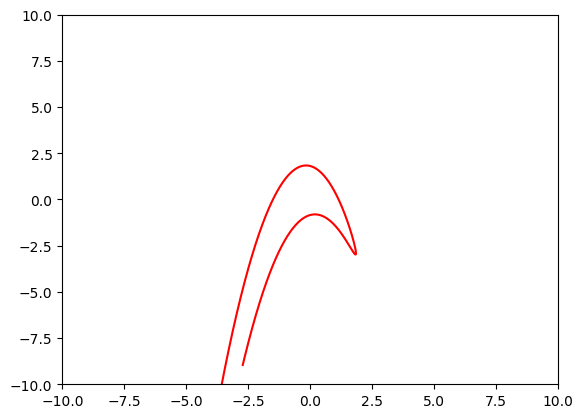

Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{BigFloat}},1}
typeof(Or1) = Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{BigFloat}},1}
typeof(AuxOr1) = Array{TaylorSeries.TaylorN{BigFloat},1}
typeof(JPO) = Array{BigFloat,2}
typeof(Coefθ) = BigFloat
typeof(Cθ) = Array{TaylorSeries.TaylorN{BigFloat},1}
typeof(λarrayθ) = Array{BigFloat,1}


(-10,10)

In [124]:
a=big(0.3)
#x2=-3.
t=[-150.,150.]
x1,x2=Parametro(a)

@show(x2)
PolinomioB,EB,ValPropB,Cx,Cy = MetParametrización(Henon,1., 35, [x2,x2], a, 1., 2, t, 0.125, BigFloat)
#PolinomioF,EF,ValPropF = MetParametrización(Henon,1., 35, Float64[x2,x2], a, 1., 1, t, 0.125, Float64)

B=evaluar(t,0.025,PolinomioB[1],PolinomioB[2])
#F=evaluar(50,0.025,PolinomioF[1],PolinomioF[2])
#pygui(true)

plot(B[1],B[2],color="r",label="estable")
#plot(F[1],F[2],color="b",label="inestable")
xlim(-10,10)
ylim(-10,10)




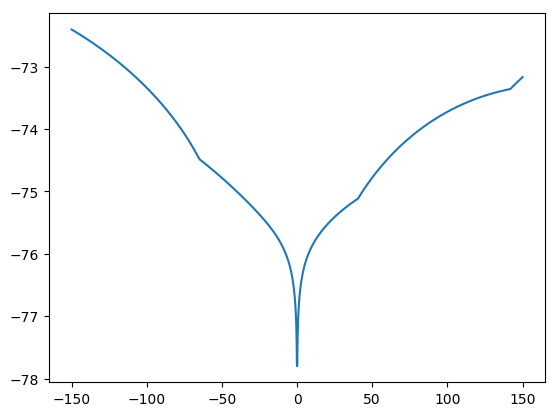

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f73665a82d0>

In [125]:
plot(EB[1],log10(EB[2]))

In [27]:
converX=[]
converY=[]
for i in 1:length(Cx)
    push!(converX,Cx[i][1][1])
    push!(converY,Cy[i][1][1])
end
plot(converX,marker=".",label="coeficientes x")
plot(converY,marker="_",label="coeficientes y")
title("Convergencia")
xlabel("Orden")
ylabel(L"$a_{n+1}/a_{n}$")
legend(loc="upper right",fancybox="true" )



LoadError: UndefVarError: Cx not defined

In [28]:
function Rotor(x,y,a,b)
   
    x_n = x+y
    y_n = y+a*x_n*(x_n-1.)*e^(-x_n)
    #=
    x_n = x+a*y
    y_n = y+x_n*(x_n -1)*e^(-x_n)
    =#

    return [x_n,y_n]
end

Rotor (generic function with 1 method)

typeof(t) = Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{BigFloat}},1}
typeof(Or1) = Array{TaylorSeries.Taylor1{TaylorSeries.TaylorN{BigFloat}},1}
typeof(AuxOr1) = Array{TaylorSeries.TaylorN{BigFloat},1}
typeof(JPO) = Array{BigFloat,2}
typeof(Coefθ) = BigFloat
typeof(Cθ) = Array{TaylorSeries.TaylorN{BigFloat},1}
typeof(λarrayθ) = Array{BigFloat,1}
A_aux = Any[]
length(A) = 36
i = 1
A[i] =  1.000000000000000000000000000000000000000000000000000000000000000000000000000000 + 𝒪(‖x‖¹)
i = 2
A[i] =  - 7.308401653623428523815068929208218080785741760637848081172882231870329935650363e-01 + 𝒪(‖x‖¹)
i = 3
A[i] =  3.427592564896947339196041652451237297140174026494481774325477173424372834957996e-80 + 𝒪(‖x‖¹)
i = 4
A[i] =  9.12419238898769001725768180616794780957445613616086469367915301597785011247276e-05 + 𝒪(‖x‖¹)
i = 5
A[i] =  2.934610157106622066914611557434342371645197158513200124889038898623187103148044e-06 + 𝒪(‖x‖¹)
i = 6
A[i] =  5.299132074192050598760401987447115510143456481568844938001737

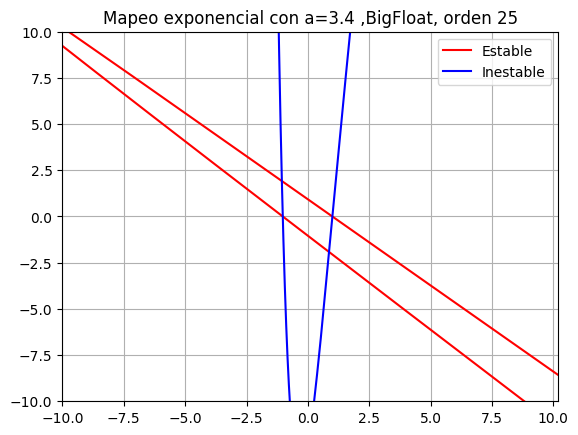

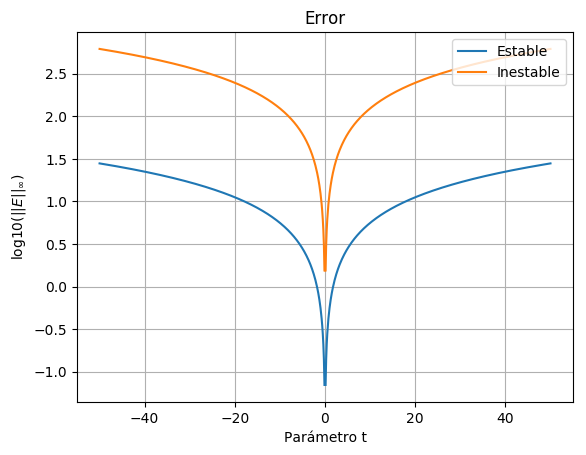

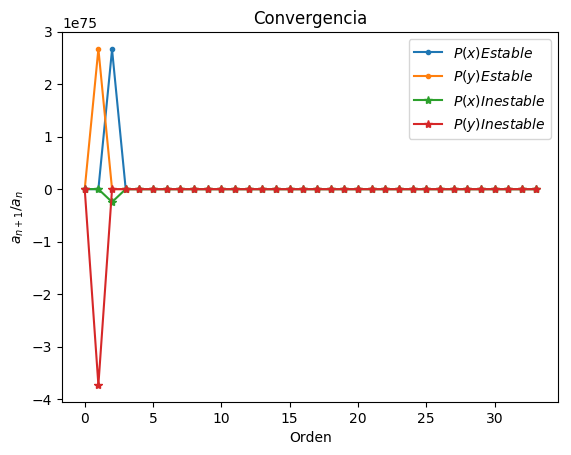

A_aux = Any[]
length(A) = 36
i = 1
A[i] =  1.000000000000000000000000000000000000000000000000000000000000000000000000000000 + 𝒪(‖x‖¹)
i = 2
A[i] =  - 7.057534075530391191277450012330480451808485575364283013479793792573915875791441e-02 + 𝒪(‖x‖¹)
i = 3
A[i] =  - 3.345438425634337657211908837585816357012883583519221187621340210714468303460841e-82 + 𝒪(‖x‖¹)
i = 4
A[i] =  8.216486831900382703970609629105163546284998701967316777340992086972064143478818e-08 + 𝒪(‖x‖¹)
i = 5
A[i] =  2.551953298334620156197195295050430954638724536433724780028885313790112260367327e-10 + 𝒪(‖x‖¹)
i = 6
A[i] =  4.449975566538895277793791983915016836524172491164202804300177163245042721678356e-13 + 𝒪(‖x‖¹)
i = 7
A[i] =  5.494944441582714331487608682846490317696807394153487904231470135103873686046549e-16 + 𝒪(‖x‖¹)
i = 8
A[i] =  5.267157272364083117084912347698742981636089723857315639125520693293271267557923e-19 + 𝒪(‖x‖¹)
i = 9
A[i] =  4.116777033638164009018066816496045582432736609346049291178265148828648788696303e-22 

PyObject <matplotlib.legend.Legend object at 0x7f8529487cd0>

In [31]:
a=big(4.4)
t=[-50.,50.]
Polinomio1F,E1F,ValProp1F,Cx1,Cy1 = MetParametrización(Rotor,1., 35, [big(1.),0.], a, 1., 1, t, 0.125, BigFloat)
Polinomio2F,E2F,ValProp2F ,Cx2,Cy2 = MetParametrización(Rotor,1., 35, [big(1.),0.], a, 1., 2, t, 0.125, BigFloat)
V=evaluar(t,0.025,Polinomio2F[1],Polinomio2F[2])
B=evaluar(t,0.025,Polinomio1F[1],Polinomio1F[2])
figure(1)
#pygui(true)
plot(B[1],B[2],color="r",label="Estable")
plot(V[1],V[2],color="b",label="Inestable")
xlim(-10,10.2)
ylim(-10,10)
title("Mapeo exponencial con a=3.4 ,BigFloat, orden 25")
grid("on")
legend(loc="upper right",fancybox="true" )


figure(2)
plot(E1F[1],log10(E1F[2]),marker= "None", label="Estable")
plot(E2F[1],log10(E2F[2]),marker= "None", label="Inestable")
xlabel("Parámetro t")
ylabel(L"log10($|| E||_{\infty})$")
title("Error")
grid("on")
legend(loc="upper right",fancybox="true" )

figure(3)
converX1=[]
converY1=[]
converX2=[]
converY2=[]
for i in 1:length(Cx1)
    push!(converX1,Cx1[i][1][1])
    push!(converY1,Cy1[i][1][1])
    push!(converX2,Cx2[i][1][1])
    push!(converY2,Cy2[i][1][1])
    
end
plot(converX1,marker=".",label=L"P(x) Estable")
plot(converY1,marker=".",label=L"P(y) Estable")
plot(converX2,marker="*",label=L"P(x) Inestable")
plot(converY2,marker="*",label=L"P(y) Inestable")

title("Convergencia")
xlabel("Orden")
ylabel(L"$a_{n+1}/a_{n}$")
legend(loc="upper right",fancybox="true" )
